In [2]:
from langchain_core.prompts import ChatPromptTemplate 
from langchain_openai import ChatOpenAI  
_llm=ChatOpenAI(
        api_key="ollama",
        model="qwen2.5:7b",
        base_url="http://0.0.0.0:60016/v1",
        temperature=0.6
    )

In [3]:
from planner import Planner
from evaluer import Executor
from planner_grand2 import Planner2
from writer import Writer

_planner = Planner(_llm)
_evaluer = Executor(_llm)
_planner_grand2 = Planner2(_llm)
_writer= Writer(_llm)

In [4]:
from typing import TypedDict
from typing import Annotated
from typing import List
from operator import add

class PlanState(TypedDict):
    query:str
    Topic:str
    outline_list:List[str]     #规约是覆盖，不用写
    advise:Annotated[List[str],add]
    Topic_Highlights:str
    content:str


In [5]:
def _planner_node(state):
    _rt = _planner(state)
    return _rt      # 返回的state 中就有了list
def _evaluer_node(state):
    _advise=state.get("advise",[]) # 初始第一个是空
    _outline_list= state["outline_list"]
    _Topic_Highlights=state["Topic_Highlights"]
    _Topic=state["Topic"]
    _query=state["query"]
    evaluation_result=_evaluer({
        "query":_query,
        "outline_list":_outline_list,
        "Topic":_Topic,
        "Topic_Highlights":_Topic_Highlights
            })
    return{"advise":[evaluation_result]}
def _planner_grand2_node(state):
    _advise=state["advise"]
    _outline_list= state["outline_list"]
    _Topic_Highlights=state["Topic_Highlights"]
    _Topic=state["Topic"]
    planner_result= _planner_grand2({
        "outline_list":_outline_list,
        "Topic":_Topic,
        "Topic_Highlights":_Topic_Highlights,
        "advise":_advise
    })
    return planner_result  #返回的state

In [6]:
def _writer_node(state):
    _query=state["query"]
    _outline_list= state["outline_list"]
    _Topic_Highlights=state["Topic_Highlights"]
    _Topic=state["Topic"]
    _rt = _writer({
        "query":_query,
        "outline_list":_outline_list,
        "Topic":_Topic,
        "Topic_Highlights":_Topic_Highlights
    })
    return {"content":_rt}

In [7]:
from langgraph.graph import StateGraph,MessagesState,START,END
_builder=StateGraph(PlanState)

_builder.add_node("_planner_node", _planner_node)
_builder.add_node("_evaluer_node", _evaluer_node)
_builder.add_node("_planner_grand2_node", _planner_grand2_node)
_builder.add_node("_writer_node", _writer_node)


_builder.add_edge(START,'_planner_node')
_builder.add_edge('_planner_node',"_evaluer_node")
_builder.add_edge('_evaluer_node',"_planner_grand2_node")
_builder.add_edge("_planner_grand2_node",'_writer_node')
_builder.add_edge('_writer_node',END)

_graph =_builder.compile()

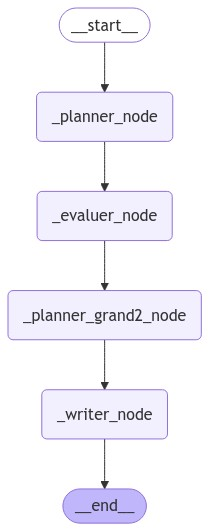

In [8]:
from IPython.display import display,Image

display(Image(_graph.get_graph().draw_mermaid_png()))

In [9]:
#for _event_dict in _graph.stream({"messages":[("human",{"query":"写一篇关于幼儿教育的课题文章，字数5000左右，要结合今年的教育热题"})]}):
# print(_event_dict)
    # for _message in _event_dict["messages"]:
    #     print(_message)

for _event_dict in _graph.stream({"query":"写一篇关于AI大模型在工业领域的结合的课题文章，字数4000左右，要结合今年的教育热题"}):
    print(_event_dict)

OutputParserException: Invalid json output: ```json
{
  "Topic": "基于AI大模型的工业应用研究：以智能制造为例",
  "outline_list": [
    "引言 (350-400字)",
      "背景介绍与研究意义",
      "当前工业领域面临的挑战及其应对策略",
    "国内外研究现状分析 (600-700字)",
      "国外先进经验分享",
      "国内发展状况和成功案例",
    "AI大模型概述 (500-600字)",
      "定义与特点介绍",
      "技术发展历程",
    "智能制造中的应用实例 (800-900字)",
      "生产过程优化",
      "质量控制与检测",
      "供应链管理与预测",
    "挑战与对策 (700-800字)",
      "数据安全与隐私问题",
      "算法透明度与解释性",
      "技术伦理和社会影响",
    "未来发展趋势 (450-500字)",
      "技术创新方向",
      "政策导向与行业规范",
      "教育热题结合分析",
  ],
  "Topic_Highlights": "本文旨在探讨人工智能大模型在工业领域的应用现状、挑战及未来趋势，尤其以智能制造为例展开深入研究。通过对比国内外的先进经验和技术发展路径，为工业4.0背景下相关企业和研究人员提供参考和借鉴。文章还将讨论教育与技术融合的重要性，并结合当前教育热点提出建议。"
}
```
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE

In [44]:
_rt=_graph.invoke({'query':"写一篇关于幼儿教育的课题文章，字数5000左右，要结合今年的教育热题"})
_rt

{'query': '写一篇关于幼儿教育的课题文章，字数5000左右，要结合今年的教育热题',
 'Topic': '基于STEAM理念的幼儿教育模式研究——以编程游戏为例',
 'outline_list': ['引言（250字）：介绍当前少子化趋势下的招生困境及普惠性幼儿园的发展挑战；说明选择该课题的理由及其研究价值。',
  '文献综述（300字）：回顾国内外关于幼儿教育的研究，特别是在普惠性幼儿园和招生困境方面的研究。探讨编程游戏在幼儿教育中的应用情况，结合热点问题进行分析。',
  '理论基础（400字）：阐述STEAM理念的基本内涵及其对幼儿教育的意义。结合编程游戏的具体案例进行分析，讨论如何通过编程游戏促进幼儿的逻辑思维和创新意识发展。',
  '编程游戏在幼儿教育中的实践现状（650字）：介绍当前编程游戏在幼儿园的应用情况，存在的问题及不足之处。探讨编程游戏如何帮助提高教育质量、解决招生困境等问题。',
  '基于编程游戏的幼儿教育模式设计（800字）：详细描述一种新的幼儿教育模式的设计思路。包括将编程游戏融入到教学大纲中的具体方法；教师的角色与职责；家长的作用等。讨论如何通过编程游戏促进幼儿全面发展，应对当前挑战。',
  '案例分析与实证研究（1200字）：选取几个典型幼儿园进行深入调研，探讨实施该教育模式的具体效果及影响因素。通过问卷调查、访谈等方式收集数据，并进行数据分析。结合热点问题，评估编程游戏在解决招生困境等方面的贡献。',
  '结论与建议（650字）：总结研究发现，提出针对幼儿教育模式改进的建议，包括政策层面和实践操作层面。强调编程游戏在促进幼儿全面发展、提高教育质量方面的作用，并探讨其对未来幼儿园课程设计的借鉴价值。',
  '参考文献（100字）：列出本论文所引用的相关学术资料'],
 'advise': ['了解了2023年幼儿教育领域的热点后，我建议你将这些信息融入你的课题中。具体来说，可以结合当前的招生困境、普惠性幼儿园的发展等热点问题，探讨编程游戏在幼儿教育中的应用如何帮助解决这些问题。\n\n### 引言（250字）\n- 介绍幼儿教育的重要性及当前面临的挑战，如少子化趋势下的招生困境。\n- 讨论选择该课题的理由及其研究价值，特别是STEAM理念与编程游戏如何应对这些挑战。\n\n### 文献综述（300字）\n- 